The code for the nlp task is greatly inspired from https://coderzcolumn.com/.

In [1]:
!pip install mxnet-cu110
!pip install shap
!pip install gluonnlp
!pip install scikit-plot
import mxnet
import gluonnlp 
import shap
import numpy as np
from sklearn import datasets
import gc
import re
from functools import partial
from collections import Counter
import gluonnlp.data.batchify as bf
from mxnet import nd,init, initializer,autograd,optimizer
from sklearn.feature_extraction.text import CountVectorizer
from mxnet.gluon.data import DataLoader , ArrayDataset
from mxnet.gluon import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from mxnet import gluon
from mxnet.gluon import loss

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
all_categories = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware',
                  'comp.sys.mac.hardware','comp.windows.x', 'misc.forsale','rec.autos','rec.motorcycles',
                  'rec.sport.baseball','rec.sport.hockey','sci.crypt','sci.electronics','sci.med',
                  'sci.space','soc.religion.christian','talk.politics.guns','talk.politics.mideast',
                  'talk.politics.misc','talk.religion.misc']

selected_categories = ['alt.atheism','comp.graphics','rec.sport.hockey','sci.space','talk.politics.misc']

X_train, Y_train = datasets.fetch_20newsgroups(subset="train", categories=selected_categories, return_X_y=True)
X_test , Y_test  = datasets.fetch_20newsgroups(subset="test", categories=selected_categories, return_X_y=True)

classes = np.unique(Y_train)
mapping = dict(zip(classes, selected_categories))

len(X_train), len(X_test), classes, mapping

(2722,
 1811,
 array([0, 1, 2, 3, 4]),
 {0: 'alt.atheism',
  1: 'comp.graphics',
  2: 'rec.sport.hockey',
  3: 'sci.space',
  4: 'talk.politics.misc'})

In [3]:
train_dataset = ArrayDataset(X_train, Y_train)
test_dataset  = ArrayDataset(X_test, Y_test)

In [4]:
tokenizer = partial(lambda X: re.findall(r"\w+", X))

tokenizer("Hello, How are you?")

['Hello', 'How', 'are', 'you']

In [5]:
counter = Counter()

for dataset in [train_dataset, test_dataset]:
    for X, Y in dataset:
        gluonnlp.data.count_tokens(tokenizer(X), to_lower=True, counter=counter)

vocab = gluonnlp.Vocab(counter=counter, min_freq=1)

print("Vocabulary Size : {}".format(len(vocab)))

Vocabulary Size : 52114


In [6]:
vocab.idx_to_token[:10]

['<unk>', '<pad>', '<bos>', '<eos>', 'the', 'to', 'of', 'a', 'and', 'in']

In [7]:
vectorizer = CountVectorizer(vocabulary=vocab.idx_to_token, tokenizer=tokenizer)

def vectorize(batch):
    X, Y = list(zip(*batch))
    X = vectorizer.transform(X).todense()
    return nd.array(X, dtype=np.float32), nd.array(Y, dtype=np.int32)

vectorize([["how are you", 1]])

(
 [[0. 0. 0. ... 0. 0. 0.]]
 <NDArray 1x52114 @cpu(0)>, 
 [1]
 <NDArray 1 @cpu(0)>)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=128, batchify_fn=vectorize)
test_loader  = DataLoader(test_dataset,  batch_size=128, batchify_fn=vectorize)

In [9]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

(128, 52114) (128,)


# Define network

In [10]:
class TextClassifier(nn.Block):
    def __init__(self, **kwargs):
        super(TextClassifier, self).__init__(**kwargs)
        self.seq  = nn.Sequential()
        self.seq.add(nn.Dense(128, activation="relu"))
        self.seq.add(nn.Dense(64, activation="relu"))
        self.seq.add(nn.Dense(len(selected_categories)))

    def forward(self, x):
        logits = self.seq(x)
        return logits #nd.softmax(logits)

model = TextClassifier()

model

TextClassifier(
  (seq): Sequential(
    (0): Dense(None -> 128, Activation(relu))
    (1): Dense(None -> 64, Activation(relu))
    (2): Dense(None -> 5, linear)
  )
)

In [11]:
model.initialize(initializer.Xavier())

preds = model(nd.random.randn(10,len(vocab)))

preds.shape

(10, 5)

In [25]:
def MakePredictions(model, val_loader):
    Y_actuals, Y_preds = [], []
    for X_batch, Y_batch in val_loader:
        preds = model(X_batch)
        preds = nd.softmax(preds)
        Y_actuals.append(Y_batch)
        Y_preds.append(preds.argmax(axis=-1))

    Y_actuals, Y_preds = nd.concatenate(Y_actuals), nd.concatenate(Y_preds)
    return Y_actuals, Y_preds

def CalcValLoss(model, val_loader):
    losses = []
    for X_batch, Y_batch in val_loader:
        val_loss = loss_func(model(X_batch), Y_batch)
        val_loss = val_loss.mean().asscalar()
        losses.append(val_loss)
    print("Valid CrossEntropyLoss : {:.3f}".format(np.array(losses).mean()))

def TrainModelInBatches(trainer, train_loader, val_loader, epochs):
    accuracies = []
    for i in range(1, epochs+1):
        losses = [] ## Record loss of each batch
        for X_batch, Y_batch in tqdm(train_loader):
            with autograd.record():
                preds = model(X_batch) ## Forward pass to make predictions
                train_loss = loss_func(preds.squeeze(), Y_batch) ## Calculate Loss
            train_loss.backward() ## Calculate Gradients

            train_loss = train_loss.mean().asscalar()
            losses.append(train_loss)

            trainer.step(len(X_batch)) ## Update weights

        print("Train CrossEntropyLoss : {:.3f}".format(np.array(losses).mean()))
        CalcValLoss(model, val_loader)
        Y_actuals, Y_preds = MakePredictions(model, val_loader)
        print("Valid Accuracy : {:.3f}".format(accuracy_score(Y_actuals.asnumpy(), Y_preds.asnumpy())))
        accuracies.append(accuracy_score(Y_actuals.asnumpy(), Y_preds.asnumpy()))
    return accuracies

# Adam

In [14]:
epochs=8
learning_rate = 0.001

model = TextClassifier()
model.initialize()
loss_func = loss.SoftmaxCrossEntropyLoss()
adam_optimizer = optimizer.Adam(learning_rate=learning_rate)

trainer = gluon.Trainer(model.collect_params(), adam_optimizer)

TrainModelInBatches(trainer, train_loader, test_loader, epochs)

100%|██████████| 22/22 [00:06<00:00,  3.56it/s]


Train CrossEntropyLoss : 1.393
Valid CrossEntropyLoss : 1.073
Valid Accuracy : 0.821


100%|██████████| 22/22 [00:06<00:00,  3.37it/s]


Train CrossEntropyLoss : 0.508
Valid CrossEntropyLoss : 0.391
Valid Accuracy : 0.922


100%|██████████| 22/22 [00:05<00:00,  4.27it/s]


Train CrossEntropyLoss : 0.080
Valid CrossEntropyLoss : 0.264
Valid Accuracy : 0.935


100%|██████████| 22/22 [00:03<00:00,  6.63it/s]


Train CrossEntropyLoss : 0.023
Valid CrossEntropyLoss : 0.245
Valid Accuracy : 0.934


100%|██████████| 22/22 [00:03<00:00,  6.63it/s]


Train CrossEntropyLoss : 0.011
Valid CrossEntropyLoss : 0.242
Valid Accuracy : 0.938


100%|██████████| 22/22 [00:03<00:00,  6.59it/s]


Train CrossEntropyLoss : 0.006
Valid CrossEntropyLoss : 0.241
Valid Accuracy : 0.936


100%|██████████| 22/22 [00:03<00:00,  6.69it/s]


Train CrossEntropyLoss : 0.004
Valid CrossEntropyLoss : 0.242
Valid Accuracy : 0.937


100%|██████████| 22/22 [00:03<00:00,  6.71it/s]


Train CrossEntropyLoss : 0.003
Valid CrossEntropyLoss : 0.244
Valid Accuracy : 0.938


Test Accuracy : 0.9381557150745444
Classification Report : 
                    precision    recall  f1-score   support

       alt.atheism       0.95      0.92      0.94       319
     comp.graphics       0.91      0.96      0.93       389
  rec.sport.hockey       0.98      0.97      0.97       399
         sci.space       0.93      0.93      0.93       394
talk.politics.misc       0.92      0.89      0.91       310

          accuracy                           0.94      1811
         macro avg       0.94      0.94      0.94      1811
      weighted avg       0.94      0.94      0.94      1811


Confusion Matrix : 
[[295   9   2   6   7]
 [  3 373   3   5   5]
 [  1   5 388   0   5]
 [  1  18   2 367   6]
 [  9   7   2  16 276]]


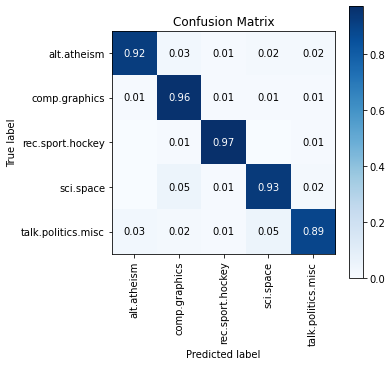

In [15]:
Y_actuals, Y_preds = MakePredictions(model, test_loader)

print("Test Accuracy : {}".format(accuracy_score(Y_actuals.asnumpy(), Y_preds.asnumpy())))
print("Classification Report : ")
print(classification_report(Y_actuals.asnumpy(), Y_preds.asnumpy(), target_names=selected_categories))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actuals.asnumpy(), Y_preds.asnumpy()))


skplt.metrics.plot_confusion_matrix([selected_categories[i] for i in Y_actuals.asnumpy().astype(int)], [selected_categories[i] for i in Y_preds.asnumpy().astype(int)],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

# DCASGD

### 1st test

In [47]:
epochs=8
results = []
for lr in np.logspace(-4,-1,5) : 
  row = []
  for lamda in np.logspace(-4,-1,5) :
    model = TextClassifier()
    model.initialize()
    loss_func = loss.SoftmaxCrossEntropyLoss()
    dcasgd_optimizer = optimizer.DCASGD(learning_rate=lr, lamda = 0)

    trainer = gluon.Trainer(model.collect_params(), dcasgd_optimizer)

    accuracies = TrainModelInBatches(trainer, train_loader, test_loader, epochs)
    row.append(accuracies)
  results.append(row)

100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


Train CrossEntropyLoss : 1.627
Valid CrossEntropyLoss : 1.630
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:07<00:00,  3.13it/s]


Train CrossEntropyLoss : 1.626
Valid CrossEntropyLoss : 1.630
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  4.55it/s]


Train CrossEntropyLoss : 1.626
Valid CrossEntropyLoss : 1.629
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:05<00:00,  3.85it/s]


Train CrossEntropyLoss : 1.625
Valid CrossEntropyLoss : 1.629
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:05<00:00,  3.82it/s]


Train CrossEntropyLoss : 1.625
Valid CrossEntropyLoss : 1.628
Valid Accuracy : 0.177


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 1.624
Valid CrossEntropyLoss : 1.628
Valid Accuracy : 0.177


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.624
Valid CrossEntropyLoss : 1.627
Valid Accuracy : 0.177


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.627
Valid Accuracy : 0.175


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train CrossEntropyLoss : 1.609
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.213


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.609
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.211


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train CrossEntropyLoss : 1.608
Valid CrossEntropyLoss : 1.614
Valid Accuracy : 0.212


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 1.608
Valid CrossEntropyLoss : 1.614
Valid Accuracy : 0.214


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.608
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.214


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.215


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.216


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.612
Valid Accuracy : 0.217


100%|██████████| 22/22 [00:03<00:00,  5.58it/s]


Train CrossEntropyLoss : 1.621
Valid CrossEntropyLoss : 1.622
Valid Accuracy : 0.232


100%|██████████| 22/22 [00:04<00:00,  4.74it/s]


Train CrossEntropyLoss : 1.621
Valid CrossEntropyLoss : 1.621
Valid Accuracy : 0.232


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train CrossEntropyLoss : 1.620
Valid CrossEntropyLoss : 1.621
Valid Accuracy : 0.232


100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


Train CrossEntropyLoss : 1.619
Valid CrossEntropyLoss : 1.620
Valid Accuracy : 0.234


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train CrossEntropyLoss : 1.618
Valid CrossEntropyLoss : 1.619
Valid Accuracy : 0.234


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.618
Valid CrossEntropyLoss : 1.619
Valid Accuracy : 0.235


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.617
Valid CrossEntropyLoss : 1.618
Valid Accuracy : 0.236


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 1.616
Valid CrossEntropyLoss : 1.618
Valid Accuracy : 0.236


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.614
Valid CrossEntropyLoss : 1.610
Valid Accuracy : 0.181


100%|██████████| 22/22 [00:03<00:00,  5.84it/s]


Train CrossEntropyLoss : 1.614
Valid CrossEntropyLoss : 1.610
Valid Accuracy : 0.181


100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.610
Valid Accuracy : 0.182


100%|██████████| 22/22 [00:03<00:00,  5.82it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.609
Valid Accuracy : 0.182


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.609
Valid Accuracy : 0.184


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train CrossEntropyLoss : 1.612
Valid CrossEntropyLoss : 1.609
Valid Accuracy : 0.182


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train CrossEntropyLoss : 1.612
Valid CrossEntropyLoss : 1.609
Valid Accuracy : 0.184


100%|██████████| 22/22 [00:04<00:00,  5.30it/s]


Train CrossEntropyLoss : 1.612
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.184


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.190


100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.191


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train CrossEntropyLoss : 1.622
Valid CrossEntropyLoss : 1.614
Valid Accuracy : 0.191


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train CrossEntropyLoss : 1.621
Valid CrossEntropyLoss : 1.614
Valid Accuracy : 0.191


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train CrossEntropyLoss : 1.621
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.191


100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


Train CrossEntropyLoss : 1.620
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.193


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train CrossEntropyLoss : 1.620
Valid CrossEntropyLoss : 1.612
Valid Accuracy : 0.193


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train CrossEntropyLoss : 1.619
Valid CrossEntropyLoss : 1.612
Valid Accuracy : 0.200


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 1.626
Valid CrossEntropyLoss : 1.629
Valid Accuracy : 0.196


100%|██████████| 22/22 [00:03<00:00,  5.70it/s]


Train CrossEntropyLoss : 1.622
Valid CrossEntropyLoss : 1.626
Valid Accuracy : 0.203


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.618
Valid CrossEntropyLoss : 1.624
Valid Accuracy : 0.205


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train CrossEntropyLoss : 1.615
Valid CrossEntropyLoss : 1.621
Valid Accuracy : 0.200


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.620
Valid Accuracy : 0.200


100%|██████████| 22/22 [00:03<00:00,  5.70it/s]


Train CrossEntropyLoss : 1.611
Valid CrossEntropyLoss : 1.618
Valid Accuracy : 0.200


100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


Train CrossEntropyLoss : 1.608
Valid CrossEntropyLoss : 1.616
Valid Accuracy : 0.203


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.205


100%|██████████| 22/22 [00:03<00:00,  5.59it/s]


Train CrossEntropyLoss : 1.611
Valid CrossEntropyLoss : 1.605
Valid Accuracy : 0.208


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train CrossEntropyLoss : 1.609
Valid CrossEntropyLoss : 1.604
Valid Accuracy : 0.215


100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.603
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.602
Valid Accuracy : 0.220


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train CrossEntropyLoss : 1.605
Valid CrossEntropyLoss : 1.601
Valid Accuracy : 0.225


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train CrossEntropyLoss : 1.603
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.227


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train CrossEntropyLoss : 1.602
Valid CrossEntropyLoss : 1.599
Valid Accuracy : 0.230


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.601
Valid CrossEntropyLoss : 1.598
Valid Accuracy : 0.232


100%|██████████| 22/22 [00:03<00:00,  5.58it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.617
Valid Accuracy : 0.181


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train CrossEntropyLoss : 1.621
Valid CrossEntropyLoss : 1.616
Valid Accuracy : 0.182


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train CrossEntropyLoss : 1.618
Valid CrossEntropyLoss : 1.614
Valid Accuracy : 0.183


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.617
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.186


100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


Train CrossEntropyLoss : 1.615
Valid CrossEntropyLoss : 1.611
Valid Accuracy : 0.191


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.610
Valid Accuracy : 0.191


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.612
Valid CrossEntropyLoss : 1.609
Valid Accuracy : 0.194


100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


Train CrossEntropyLoss : 1.610
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.198


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train CrossEntropyLoss : 1.628
Valid CrossEntropyLoss : 1.634
Valid Accuracy : 0.209


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.630
Valid Accuracy : 0.209


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train CrossEntropyLoss : 1.619
Valid CrossEntropyLoss : 1.626
Valid Accuracy : 0.210


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train CrossEntropyLoss : 1.615
Valid CrossEntropyLoss : 1.622
Valid Accuracy : 0.212


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 1.612
Valid CrossEntropyLoss : 1.619
Valid Accuracy : 0.214


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train CrossEntropyLoss : 1.609
Valid CrossEntropyLoss : 1.617
Valid Accuracy : 0.216


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.614
Valid Accuracy : 0.220


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train CrossEntropyLoss : 1.605
Valid CrossEntropyLoss : 1.612
Valid Accuracy : 0.223


100%|██████████| 22/22 [00:03<00:00,  5.60it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.607
Valid Accuracy : 0.187


100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


Train CrossEntropyLoss : 1.611
Valid CrossEntropyLoss : 1.606
Valid Accuracy : 0.186


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 1.609
Valid CrossEntropyLoss : 1.604
Valid Accuracy : 0.192


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.603
Valid Accuracy : 0.198


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.602
Valid Accuracy : 0.201


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 1.604
Valid CrossEntropyLoss : 1.601
Valid Accuracy : 0.203


100%|██████████| 22/22 [00:04<00:00,  4.58it/s]


Train CrossEntropyLoss : 1.603
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.199


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.601
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.201


100%|██████████| 22/22 [00:03<00:00,  5.62it/s]


Train CrossEntropyLoss : 1.610
Valid CrossEntropyLoss : 1.603
Valid Accuracy : 0.211


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.602
Valid CrossEntropyLoss : 1.598
Valid Accuracy : 0.235


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.596
Valid CrossEntropyLoss : 1.594
Valid Accuracy : 0.247


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.591
Valid CrossEntropyLoss : 1.591
Valid Accuracy : 0.263


100%|██████████| 22/22 [00:03<00:00,  5.70it/s]


Train CrossEntropyLoss : 1.587
Valid CrossEntropyLoss : 1.588
Valid Accuracy : 0.272


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train CrossEntropyLoss : 1.583
Valid CrossEntropyLoss : 1.585
Valid Accuracy : 0.275


100%|██████████| 22/22 [00:03<00:00,  5.83it/s]


Train CrossEntropyLoss : 1.579
Valid CrossEntropyLoss : 1.582
Valid Accuracy : 0.284


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 1.576
Valid CrossEntropyLoss : 1.579
Valid Accuracy : 0.293


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.615
Valid CrossEntropyLoss : 1.621
Valid Accuracy : 0.177


100%|██████████| 22/22 [00:03<00:00,  5.62it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.186


100%|██████████| 22/22 [00:03<00:00,  5.58it/s]


Train CrossEntropyLoss : 1.601
Valid CrossEntropyLoss : 1.610
Valid Accuracy : 0.197


100%|██████████| 22/22 [00:03<00:00,  5.60it/s]


Train CrossEntropyLoss : 1.595
Valid CrossEntropyLoss : 1.605
Valid Accuracy : 0.221


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Train CrossEntropyLoss : 1.589
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.233


100%|██████████| 22/22 [00:03<00:00,  5.59it/s]


Train CrossEntropyLoss : 1.584
Valid CrossEntropyLoss : 1.595
Valid Accuracy : 0.248


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Train CrossEntropyLoss : 1.579
Valid CrossEntropyLoss : 1.591
Valid Accuracy : 0.255


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train CrossEntropyLoss : 1.574
Valid CrossEntropyLoss : 1.587
Valid Accuracy : 0.272


100%|██████████| 22/22 [00:04<00:00,  5.31it/s]


Train CrossEntropyLoss : 1.614
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.190


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.604
Valid CrossEntropyLoss : 1.602
Valid Accuracy : 0.200


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.597
Valid CrossEntropyLoss : 1.598
Valid Accuracy : 0.226


100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


Train CrossEntropyLoss : 1.591
Valid CrossEntropyLoss : 1.595
Valid Accuracy : 0.236


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.586
Valid CrossEntropyLoss : 1.591
Valid Accuracy : 0.253


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train CrossEntropyLoss : 1.582
Valid CrossEntropyLoss : 1.588
Valid Accuracy : 0.271


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.577
Valid CrossEntropyLoss : 1.584
Valid Accuracy : 0.288


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.573
Valid CrossEntropyLoss : 1.581
Valid Accuracy : 0.305


100%|██████████| 22/22 [00:04<00:00,  5.21it/s]


Train CrossEntropyLoss : 1.620
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.247


100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


Train CrossEntropyLoss : 1.599
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.277


100%|██████████| 22/22 [00:04<00:00,  5.33it/s]


Train CrossEntropyLoss : 1.590
Valid CrossEntropyLoss : 1.595
Valid Accuracy : 0.294


100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Train CrossEntropyLoss : 1.584
Valid CrossEntropyLoss : 1.591
Valid Accuracy : 0.297


100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


Train CrossEntropyLoss : 1.579
Valid CrossEntropyLoss : 1.587
Valid Accuracy : 0.313


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.575
Valid CrossEntropyLoss : 1.583
Valid Accuracy : 0.325


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.570
Valid CrossEntropyLoss : 1.579
Valid Accuracy : 0.337


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.566
Valid CrossEntropyLoss : 1.575
Valid Accuracy : 0.348


100%|██████████| 22/22 [00:04<00:00,  5.26it/s]


Train CrossEntropyLoss : 1.609
Valid CrossEntropyLoss : 1.610
Valid Accuracy : 0.219


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.599
Valid CrossEntropyLoss : 1.604
Valid Accuracy : 0.230


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.594
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.237


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.589
Valid CrossEntropyLoss : 1.597
Valid Accuracy : 0.241


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.586
Valid CrossEntropyLoss : 1.594
Valid Accuracy : 0.252


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.582
Valid CrossEntropyLoss : 1.591
Valid Accuracy : 0.263


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train CrossEntropyLoss : 1.578
Valid CrossEntropyLoss : 1.588
Valid Accuracy : 0.276


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.575
Valid CrossEntropyLoss : 1.585
Valid Accuracy : 0.284


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.605
Valid CrossEntropyLoss : 1.592
Valid Accuracy : 0.250


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train CrossEntropyLoss : 1.581
Valid CrossEntropyLoss : 1.574
Valid Accuracy : 0.301


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.558
Valid CrossEntropyLoss : 1.554
Valid Accuracy : 0.359


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.534
Valid CrossEntropyLoss : 1.533
Valid Accuracy : 0.406


100%|██████████| 22/22 [00:03<00:00,  5.60it/s]


Train CrossEntropyLoss : 1.506
Valid CrossEntropyLoss : 1.508
Valid Accuracy : 0.458


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.471
Valid CrossEntropyLoss : 1.478
Valid Accuracy : 0.489


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 1.430
Valid CrossEntropyLoss : 1.443
Valid Accuracy : 0.506


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.381
Valid CrossEntropyLoss : 1.401
Valid Accuracy : 0.530


100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


Train CrossEntropyLoss : 1.600
Valid CrossEntropyLoss : 1.590
Valid Accuracy : 0.309


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.567
Valid CrossEntropyLoss : 1.567
Valid Accuracy : 0.366


100%|██████████| 22/22 [00:03<00:00,  5.61it/s]


Train CrossEntropyLoss : 1.544
Valid CrossEntropyLoss : 1.546
Valid Accuracy : 0.390


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.517
Valid CrossEntropyLoss : 1.520
Valid Accuracy : 0.419


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.486
Valid CrossEntropyLoss : 1.490
Valid Accuracy : 0.456


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.447
Valid CrossEntropyLoss : 1.453
Valid Accuracy : 0.491


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.401
Valid CrossEntropyLoss : 1.411
Valid Accuracy : 0.514


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.347
Valid CrossEntropyLoss : 1.363
Valid Accuracy : 0.537


100%|██████████| 22/22 [00:03<00:00,  5.55it/s]


Train CrossEntropyLoss : 1.603
Valid CrossEntropyLoss : 1.596
Valid Accuracy : 0.254


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.579
Valid CrossEntropyLoss : 1.578
Valid Accuracy : 0.291


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.559
Valid CrossEntropyLoss : 1.560
Valid Accuracy : 0.338


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.538
Valid CrossEntropyLoss : 1.540
Valid Accuracy : 0.382


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.513
Valid CrossEntropyLoss : 1.515
Valid Accuracy : 0.422


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.482
Valid CrossEntropyLoss : 1.486
Valid Accuracy : 0.463


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.446
Valid CrossEntropyLoss : 1.453
Valid Accuracy : 0.487


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 1.404
Valid CrossEntropyLoss : 1.414
Valid Accuracy : 0.525


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 1.600
Valid CrossEntropyLoss : 1.586
Valid Accuracy : 0.275


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.571
Valid CrossEntropyLoss : 1.570
Valid Accuracy : 0.308


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.552
Valid CrossEntropyLoss : 1.552
Valid Accuracy : 0.334


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.531
Valid CrossEntropyLoss : 1.532
Valid Accuracy : 0.371


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.506
Valid CrossEntropyLoss : 1.509
Valid Accuracy : 0.405


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.474
Valid CrossEntropyLoss : 1.480
Valid Accuracy : 0.445


100%|██████████| 22/22 [00:03<00:00,  5.61it/s]


Train CrossEntropyLoss : 1.436
Valid CrossEntropyLoss : 1.446
Valid Accuracy : 0.478


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.389
Valid CrossEntropyLoss : 1.403
Valid Accuracy : 0.515


100%|██████████| 22/22 [00:03<00:00,  5.54it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.596
Valid Accuracy : 0.257


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.576
Valid CrossEntropyLoss : 1.577
Valid Accuracy : 0.303


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.553
Valid CrossEntropyLoss : 1.557
Valid Accuracy : 0.351


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.527
Valid CrossEntropyLoss : 1.534
Valid Accuracy : 0.380


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.498
Valid CrossEntropyLoss : 1.508
Valid Accuracy : 0.432


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 1.463
Valid CrossEntropyLoss : 1.477
Valid Accuracy : 0.456


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 1.422
Valid CrossEntropyLoss : 1.442
Valid Accuracy : 0.482


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.374
Valid CrossEntropyLoss : 1.402
Valid Accuracy : 0.516


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.572
Valid CrossEntropyLoss : 1.545
Valid Accuracy : 0.283


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.449
Valid CrossEntropyLoss : 1.453
Valid Accuracy : 0.330


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.484
Valid CrossEntropyLoss : 1.550
Valid Accuracy : 0.340


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 1.349
Valid CrossEntropyLoss : 1.425
Valid Accuracy : 0.383


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.172
Valid CrossEntropyLoss : 0.964
Valid Accuracy : 0.726


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.336
Valid CrossEntropyLoss : 0.987
Valid Accuracy : 0.727


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.138
Valid CrossEntropyLoss : 0.965
Valid Accuracy : 0.637


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 0.948
Valid CrossEntropyLoss : 0.830
Valid Accuracy : 0.736


100%|██████████| 22/22 [00:04<00:00,  4.45it/s]


Train CrossEntropyLoss : 1.559
Valid CrossEntropyLoss : 1.526
Valid Accuracy : 0.308


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.527
Valid CrossEntropyLoss : 1.510
Valid Accuracy : 0.401


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 1.339
Valid CrossEntropyLoss : 1.261
Valid Accuracy : 0.500


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.104
Valid CrossEntropyLoss : 1.312
Valid Accuracy : 0.554


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 0.962
Valid CrossEntropyLoss : 0.777
Valid Accuracy : 0.754


100%|██████████| 22/22 [00:03<00:00,  5.70it/s]


Train CrossEntropyLoss : 1.267
Valid CrossEntropyLoss : 1.142
Valid Accuracy : 0.564


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 0.874
Valid CrossEntropyLoss : 1.315
Valid Accuracy : 0.563


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 0.679
Valid CrossEntropyLoss : 0.991
Valid Accuracy : 0.638


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.569
Valid CrossEntropyLoss : 1.525
Valid Accuracy : 0.311


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.463
Valid CrossEntropyLoss : 1.420
Valid Accuracy : 0.429


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.382
Valid CrossEntropyLoss : 1.418
Valid Accuracy : 0.401


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 1.414
Valid CrossEntropyLoss : 1.328
Valid Accuracy : 0.518


100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


Train CrossEntropyLoss : 1.154
Valid CrossEntropyLoss : 1.069
Valid Accuracy : 0.600


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.670
Valid CrossEntropyLoss : 1.178
Valid Accuracy : 0.611


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.158
Valid CrossEntropyLoss : 0.978
Valid Accuracy : 0.649


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.414
Valid CrossEntropyLoss : 1.460
Valid Accuracy : 0.358


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : 1.567
Valid CrossEntropyLoss : 1.559
Valid Accuracy : 0.255


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.448
Valid CrossEntropyLoss : 1.468
Valid Accuracy : 0.309


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.382
Valid CrossEntropyLoss : 1.280
Valid Accuracy : 0.461


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 1.181
Valid CrossEntropyLoss : 1.113
Valid Accuracy : 0.591


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 1.230
Valid CrossEntropyLoss : 1.314
Valid Accuracy : 0.537


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 0.888
Valid CrossEntropyLoss : 0.810
Valid Accuracy : 0.723


100%|██████████| 22/22 [00:03<00:00,  5.62it/s]


Train CrossEntropyLoss : 1.058
Valid CrossEntropyLoss : 1.046
Valid Accuracy : 0.627


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 0.688
Valid CrossEntropyLoss : 1.228
Valid Accuracy : 0.629


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.563
Valid CrossEntropyLoss : 1.541
Valid Accuracy : 0.267


100%|██████████| 22/22 [00:03<00:00,  5.59it/s]


Train CrossEntropyLoss : 1.429
Valid CrossEntropyLoss : 1.344
Valid Accuracy : 0.491


100%|██████████| 22/22 [00:03<00:00,  5.60it/s]


Train CrossEntropyLoss : 1.535
Valid CrossEntropyLoss : 1.349
Valid Accuracy : 0.532


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.331
Valid CrossEntropyLoss : 1.233
Valid Accuracy : 0.584


100%|██████████| 22/22 [00:03<00:00,  5.61it/s]


Train CrossEntropyLoss : 0.989
Valid CrossEntropyLoss : 0.942
Valid Accuracy : 0.654


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.467
Valid CrossEntropyLoss : 1.074
Valid Accuracy : 0.534


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.006
Valid CrossEntropyLoss : 0.859
Valid Accuracy : 0.727


100%|██████████| 22/22 [00:03<00:00,  5.61it/s]


Train CrossEntropyLoss : 0.944
Valid CrossEntropyLoss : 2.477
Valid Accuracy : 0.395


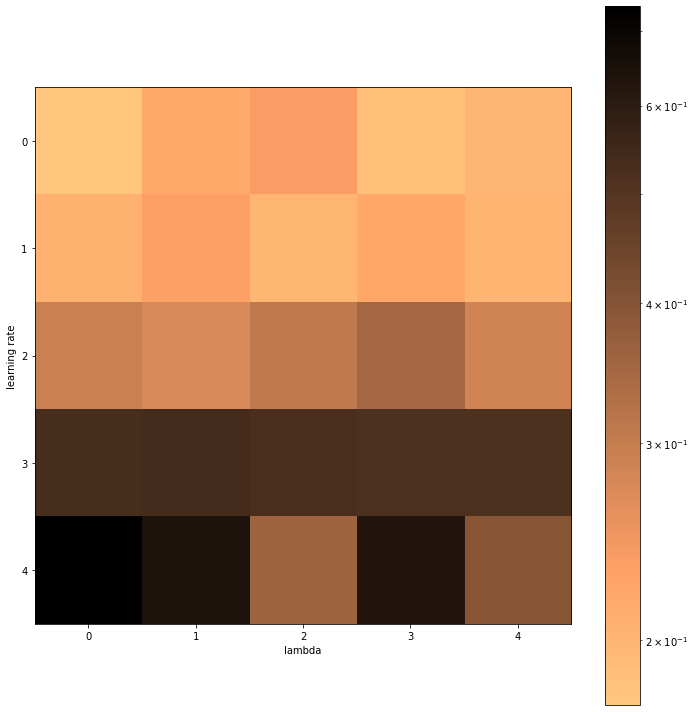

In [48]:
from matplotlib import colors as cl
to_plot = []
for lr in range(5):
  row = []
  for lamda in range(5):
    row.append(results[lr][lamda][-1])
  to_plot.append(row)
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
data2D = results
im = plt.imshow(to_plot, cmap="copper_r", norm=cl.LogNorm())
plt.xlabel('lambda')
plt.ylabel('learning rate')
plt.colorbar(im)
plt.show()

### Increase definition

In [87]:
epochs=8
results_dcasgd = []
for lr in np.logspace(-4,0,7) : 
  row = []
  for lamda in np.logspace(-4,-1,5) :
    model = TextClassifier()
    model.initialize()
    loss_func = loss.SoftmaxCrossEntropyLoss()
    dcasgd_optimizer = optimizer.DCASGD(learning_rate=lr, lamda = lamda)

    trainer = gluon.Trainer(model.collect_params(), dcasgd_optimizer)

    accuracies = TrainModelInBatches(trainer, train_loader, test_loader, epochs)
    row.append(accuracies)
  results_dcasgd.append(row)

100%|██████████| 22/22 [00:03<00:00,  5.59it/s]


Train CrossEntropyLoss : 1.654
Valid CrossEntropyLoss : 1.658
Valid Accuracy : 0.215


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train CrossEntropyLoss : 1.652
Valid CrossEntropyLoss : 1.656
Valid Accuracy : 0.216


100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


Train CrossEntropyLoss : 1.650
Valid CrossEntropyLoss : 1.654
Valid Accuracy : 0.215


100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


Train CrossEntropyLoss : 1.648
Valid CrossEntropyLoss : 1.653
Valid Accuracy : 0.216


100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


Train CrossEntropyLoss : 1.647
Valid CrossEntropyLoss : 1.651
Valid Accuracy : 0.217


100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


Train CrossEntropyLoss : 1.645
Valid CrossEntropyLoss : 1.649
Valid Accuracy : 0.216


100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


Train CrossEntropyLoss : 1.644
Valid CrossEntropyLoss : 1.648
Valid Accuracy : 0.215


100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


Train CrossEntropyLoss : 1.642
Valid CrossEntropyLoss : 1.646
Valid Accuracy : 0.214


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 1.627
Valid CrossEntropyLoss : 1.627
Valid Accuracy : 0.175


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train CrossEntropyLoss : 1.627
Valid CrossEntropyLoss : 1.626
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


Train CrossEntropyLoss : 1.626
Valid CrossEntropyLoss : 1.625
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 1.625
Valid CrossEntropyLoss : 1.624
Valid Accuracy : 0.177


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 1.624
Valid CrossEntropyLoss : 1.624
Valid Accuracy : 0.178


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.623
Valid Accuracy : 0.179


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.622
Valid Accuracy : 0.179


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train CrossEntropyLoss : 1.622
Valid CrossEntropyLoss : 1.622
Valid Accuracy : 0.181


100%|██████████| 22/22 [00:03<00:00,  5.58it/s]


Train CrossEntropyLoss : 1.615
Valid CrossEntropyLoss : 1.619
Valid Accuracy : 0.188


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.614
Valid CrossEntropyLoss : 1.619
Valid Accuracy : 0.192


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 1.614
Valid CrossEntropyLoss : 1.618
Valid Accuracy : 0.192


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.617
Valid Accuracy : 0.192


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train CrossEntropyLoss : 1.612
Valid CrossEntropyLoss : 1.617
Valid Accuracy : 0.193


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.612
Valid CrossEntropyLoss : 1.616
Valid Accuracy : 0.195


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.611
Valid CrossEntropyLoss : 1.616
Valid Accuracy : 0.196


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.610
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.196


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 1.640
Valid CrossEntropyLoss : 1.637
Valid Accuracy : 0.209


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.639
Valid CrossEntropyLoss : 1.636
Valid Accuracy : 0.209


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.638
Valid CrossEntropyLoss : 1.635
Valid Accuracy : 0.210


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.637
Valid CrossEntropyLoss : 1.635
Valid Accuracy : 0.211


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.636
Valid CrossEntropyLoss : 1.634
Valid Accuracy : 0.211


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.635
Valid CrossEntropyLoss : 1.633
Valid Accuracy : 0.213


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 1.634
Valid CrossEntropyLoss : 1.632
Valid Accuracy : 0.214


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 1.633
Valid CrossEntropyLoss : 1.632
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train CrossEntropyLoss : 1.624
Valid CrossEntropyLoss : 1.618
Valid Accuracy : 0.204


100%|██████████| 22/22 [00:03<00:00,  5.70it/s]


Train CrossEntropyLoss : 1.624
Valid CrossEntropyLoss : 1.617
Valid Accuracy : 0.207


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.617
Valid Accuracy : 0.208


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.622
Valid CrossEntropyLoss : 1.616
Valid Accuracy : 0.207


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.622
Valid CrossEntropyLoss : 1.616
Valid Accuracy : 0.208


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.621
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.210


100%|██████████| 22/22 [00:04<00:00,  4.95it/s]


Train CrossEntropyLoss : 1.620
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.209


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 1.620
Valid CrossEntropyLoss : 1.614
Valid Accuracy : 0.209


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train CrossEntropyLoss : 1.630
Valid CrossEntropyLoss : 1.620
Valid Accuracy : 0.197


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 1.627
Valid CrossEntropyLoss : 1.619
Valid Accuracy : 0.199


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 1.625
Valid CrossEntropyLoss : 1.617
Valid Accuracy : 0.200


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.616
Valid Accuracy : 0.204


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.621
Valid CrossEntropyLoss : 1.614
Valid Accuracy : 0.203


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.619
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.205


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.617
Valid CrossEntropyLoss : 1.612
Valid Accuracy : 0.210


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.615
Valid CrossEntropyLoss : 1.610
Valid Accuracy : 0.213


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 1.611
Valid CrossEntropyLoss : 1.611
Valid Accuracy : 0.190


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 1.610
Valid CrossEntropyLoss : 1.610
Valid Accuracy : 0.200


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.608
Valid CrossEntropyLoss : 1.609
Valid Accuracy : 0.203


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.210


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.607
Valid Accuracy : 0.212


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.604
Valid CrossEntropyLoss : 1.607
Valid Accuracy : 0.216


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 1.603
Valid CrossEntropyLoss : 1.606
Valid Accuracy : 0.219


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 1.602
Valid CrossEntropyLoss : 1.605
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:04<00:00,  5.35it/s]


Train CrossEntropyLoss : 1.625
Valid CrossEntropyLoss : 1.621
Valid Accuracy : 0.214


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.619
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


Train CrossEntropyLoss : 1.620
Valid CrossEntropyLoss : 1.618
Valid Accuracy : 0.223


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Train CrossEntropyLoss : 1.618
Valid CrossEntropyLoss : 1.617
Valid Accuracy : 0.230


100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


Train CrossEntropyLoss : 1.616
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.232


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : 1.615
Valid CrossEntropyLoss : 1.614
Valid Accuracy : 0.235


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.234


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.612
Valid CrossEntropyLoss : 1.612
Valid Accuracy : 0.237


100%|██████████| 22/22 [00:04<00:00,  5.26it/s]


Train CrossEntropyLoss : 1.650
Valid CrossEntropyLoss : 1.631
Valid Accuracy : 0.179


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.644
Valid CrossEntropyLoss : 1.627
Valid Accuracy : 0.173


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.638
Valid CrossEntropyLoss : 1.623
Valid Accuracy : 0.166


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.634
Valid CrossEntropyLoss : 1.621
Valid Accuracy : 0.161


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.630
Valid CrossEntropyLoss : 1.618
Valid Accuracy : 0.161


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.627
Valid CrossEntropyLoss : 1.616
Valid Accuracy : 0.166


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.624
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.173


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.621
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.170


100%|██████████| 22/22 [00:04<00:00,  5.28it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.609
Valid Accuracy : 0.230


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.612
Valid CrossEntropyLoss : 1.607
Valid Accuracy : 0.229


100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


Train CrossEntropyLoss : 1.610
Valid CrossEntropyLoss : 1.606
Valid Accuracy : 0.228


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train CrossEntropyLoss : 1.609
Valid CrossEntropyLoss : 1.605
Valid Accuracy : 0.229


100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


Train CrossEntropyLoss : 1.608
Valid CrossEntropyLoss : 1.604
Valid Accuracy : 0.236


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.603
Valid Accuracy : 0.237


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.602
Valid Accuracy : 0.239


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.605
Valid CrossEntropyLoss : 1.602
Valid Accuracy : 0.239


100%|██████████| 22/22 [00:04<00:00,  5.14it/s]


Train CrossEntropyLoss : 1.635
Valid CrossEntropyLoss : 1.625
Valid Accuracy : 0.195


100%|██████████| 22/22 [00:04<00:00,  5.37it/s]


Train CrossEntropyLoss : 1.615
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.219


100%|██████████| 22/22 [00:04<00:00,  5.34it/s]


Train CrossEntropyLoss : 1.605
Valid CrossEntropyLoss : 1.609
Valid Accuracy : 0.235


100%|██████████| 22/22 [00:04<00:00,  5.32it/s]


Train CrossEntropyLoss : 1.600
Valid CrossEntropyLoss : 1.606
Valid Accuracy : 0.250


100%|██████████| 22/22 [00:04<00:00,  5.36it/s]


Train CrossEntropyLoss : 1.596
Valid CrossEntropyLoss : 1.603
Valid Accuracy : 0.259


100%|██████████| 22/22 [00:04<00:00,  5.32it/s]


Train CrossEntropyLoss : 1.593
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.269


100%|██████████| 22/22 [00:04<00:00,  5.35it/s]


Train CrossEntropyLoss : 1.590
Valid CrossEntropyLoss : 1.598
Valid Accuracy : 0.272


100%|██████████| 22/22 [00:04<00:00,  5.37it/s]


Train CrossEntropyLoss : 1.587
Valid CrossEntropyLoss : 1.595
Valid Accuracy : 0.278


100%|██████████| 22/22 [00:04<00:00,  5.23it/s]


Train CrossEntropyLoss : 1.615
Valid CrossEntropyLoss : 1.604
Valid Accuracy : 0.210


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.231


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.601
Valid CrossEntropyLoss : 1.597
Valid Accuracy : 0.242


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.597
Valid CrossEntropyLoss : 1.595
Valid Accuracy : 0.250


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.593
Valid CrossEntropyLoss : 1.592
Valid Accuracy : 0.259


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.590
Valid CrossEntropyLoss : 1.590
Valid Accuracy : 0.269


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.587
Valid CrossEntropyLoss : 1.588
Valid Accuracy : 0.279


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.583
Valid CrossEntropyLoss : 1.585
Valid Accuracy : 0.289


100%|██████████| 22/22 [00:04<00:00,  5.26it/s]


Train CrossEntropyLoss : 1.656
Valid CrossEntropyLoss : 1.636
Valid Accuracy : 0.216


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.633
Valid CrossEntropyLoss : 1.621
Valid Accuracy : 0.219


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.619
Valid CrossEntropyLoss : 1.612
Valid Accuracy : 0.222


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.610
Valid CrossEntropyLoss : 1.606
Valid Accuracy : 0.225


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.604
Valid CrossEntropyLoss : 1.602
Valid Accuracy : 0.230


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.599
Valid CrossEntropyLoss : 1.598
Valid Accuracy : 0.238


100%|██████████| 22/22 [00:04<00:00,  5.27it/s]


Train CrossEntropyLoss : 1.594
Valid CrossEntropyLoss : 1.595
Valid Accuracy : 0.245


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.591
Valid CrossEntropyLoss : 1.592
Valid Accuracy : 0.250


100%|██████████| 22/22 [00:04<00:00,  5.26it/s]


Train CrossEntropyLoss : 1.622
Valid CrossEntropyLoss : 1.618
Valid Accuracy : 0.235


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.614
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.237


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.609
Valid CrossEntropyLoss : 1.609
Valid Accuracy : 0.246


100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


Train CrossEntropyLoss : 1.604
Valid CrossEntropyLoss : 1.607
Valid Accuracy : 0.260


100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


Train CrossEntropyLoss : 1.601
Valid CrossEntropyLoss : 1.604
Valid Accuracy : 0.265


100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Train CrossEntropyLoss : 1.598
Valid CrossEntropyLoss : 1.602
Valid Accuracy : 0.274


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.595
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.283


100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


Train CrossEntropyLoss : 1.592
Valid CrossEntropyLoss : 1.598
Valid Accuracy : 0.291


100%|██████████| 22/22 [00:04<00:00,  5.24it/s]


Train CrossEntropyLoss : 1.620
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.203


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.611
Valid CrossEntropyLoss : 1.610
Valid Accuracy : 0.225


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.604
Valid CrossEntropyLoss : 1.605
Valid Accuracy : 0.243


100%|██████████| 22/22 [00:04<00:00,  4.74it/s]


Train CrossEntropyLoss : 1.598
Valid CrossEntropyLoss : 1.601
Valid Accuracy : 0.256


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.592
Valid CrossEntropyLoss : 1.597
Valid Accuracy : 0.266


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.588
Valid CrossEntropyLoss : 1.594
Valid Accuracy : 0.281


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.584
Valid CrossEntropyLoss : 1.591
Valid Accuracy : 0.290


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.581
Valid CrossEntropyLoss : 1.589
Valid Accuracy : 0.302


100%|██████████| 22/22 [00:04<00:00,  5.29it/s]


Train CrossEntropyLoss : 1.618
Valid CrossEntropyLoss : 1.606
Valid Accuracy : 0.228


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.591
Valid CrossEntropyLoss : 1.590
Valid Accuracy : 0.288


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.576
Valid CrossEntropyLoss : 1.578
Valid Accuracy : 0.334


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.563
Valid CrossEntropyLoss : 1.567
Valid Accuracy : 0.377


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.550
Valid CrossEntropyLoss : 1.555
Valid Accuracy : 0.404


100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Train CrossEntropyLoss : 1.536
Valid CrossEntropyLoss : 1.542
Valid Accuracy : 0.430


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.521
Valid CrossEntropyLoss : 1.528
Valid Accuracy : 0.446


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train CrossEntropyLoss : 1.504
Valid CrossEntropyLoss : 1.512
Valid Accuracy : 0.467


100%|██████████| 22/22 [00:04<00:00,  5.29it/s]


Train CrossEntropyLoss : 1.598
Valid CrossEntropyLoss : 1.595
Valid Accuracy : 0.247


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.581
Valid CrossEntropyLoss : 1.583
Valid Accuracy : 0.281


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.567
Valid CrossEntropyLoss : 1.572
Valid Accuracy : 0.305


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.554
Valid CrossEntropyLoss : 1.559
Valid Accuracy : 0.329


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train CrossEntropyLoss : 1.540
Valid CrossEntropyLoss : 1.546
Valid Accuracy : 0.351


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.526
Valid CrossEntropyLoss : 1.533
Valid Accuracy : 0.382


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.510
Valid CrossEntropyLoss : 1.518
Valid Accuracy : 0.409


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 1.493
Valid CrossEntropyLoss : 1.503
Valid Accuracy : 0.425


100%|██████████| 22/22 [00:04<00:00,  5.36it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.241


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.589
Valid CrossEntropyLoss : 1.591
Valid Accuracy : 0.267


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.578
Valid CrossEntropyLoss : 1.583
Valid Accuracy : 0.292


100%|██████████| 22/22 [00:03<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.568
Valid CrossEntropyLoss : 1.574
Valid Accuracy : 0.311


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.557
Valid CrossEntropyLoss : 1.565
Valid Accuracy : 0.337


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : 1.546
Valid CrossEntropyLoss : 1.554
Valid Accuracy : 0.356


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.533
Valid CrossEntropyLoss : 1.543
Valid Accuracy : 0.379


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.519
Valid CrossEntropyLoss : 1.530
Valid Accuracy : 0.405


100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Train CrossEntropyLoss : 1.600
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.267


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.583
Valid CrossEntropyLoss : 1.590
Valid Accuracy : 0.313


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 1.571
Valid CrossEntropyLoss : 1.581
Valid Accuracy : 0.342


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.560
Valid CrossEntropyLoss : 1.572
Valid Accuracy : 0.364


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.549
Valid CrossEntropyLoss : 1.562
Valid Accuracy : 0.384


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.538
Valid CrossEntropyLoss : 1.551
Valid Accuracy : 0.413


100%|██████████| 22/22 [00:03<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.525
Valid CrossEntropyLoss : 1.539
Valid Accuracy : 0.431


100%|██████████| 22/22 [00:03<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.511
Valid CrossEntropyLoss : 1.525
Valid Accuracy : 0.447


100%|██████████| 22/22 [00:04<00:00,  5.29it/s]


Train CrossEntropyLoss : 1.624
Valid CrossEntropyLoss : 1.605
Valid Accuracy : 0.245


100%|██████████| 22/22 [00:04<00:00,  4.82it/s]


Train CrossEntropyLoss : 1.593
Valid CrossEntropyLoss : 1.586
Valid Accuracy : 0.292


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 1.574
Valid CrossEntropyLoss : 1.573
Valid Accuracy : 0.332


100%|██████████| 22/22 [00:03<00:00,  5.54it/s]


Train CrossEntropyLoss : 1.559
Valid CrossEntropyLoss : 1.560
Valid Accuracy : 0.362


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.545
Valid CrossEntropyLoss : 1.547
Valid Accuracy : 0.399


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.531
Valid CrossEntropyLoss : 1.534
Valid Accuracy : 0.423


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.517
Valid CrossEntropyLoss : 1.521
Valid Accuracy : 0.446


100%|██████████| 22/22 [00:03<00:00,  5.55it/s]


Train CrossEntropyLoss : 1.501
Valid CrossEntropyLoss : 1.506
Valid Accuracy : 0.470


100%|██████████| 22/22 [00:04<00:00,  5.37it/s]


Train CrossEntropyLoss : 1.597
Valid CrossEntropyLoss : 1.584
Valid Accuracy : 0.253


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.543
Valid CrossEntropyLoss : 1.546
Valid Accuracy : 0.297


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.479
Valid CrossEntropyLoss : 1.498
Valid Accuracy : 0.343


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.380
Valid CrossEntropyLoss : 1.469
Valid Accuracy : 0.382


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.244
Valid CrossEntropyLoss : 1.259
Valid Accuracy : 0.549


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.287
Valid CrossEntropyLoss : 1.200
Valid Accuracy : 0.623


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 0.969
Valid CrossEntropyLoss : 0.976
Valid Accuracy : 0.718


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 0.913
Valid CrossEntropyLoss : 0.979
Valid Accuracy : 0.724


100%|██████████| 22/22 [00:04<00:00,  5.37it/s]


Train CrossEntropyLoss : 1.590
Valid CrossEntropyLoss : 1.568
Valid Accuracy : 0.306


100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


Train CrossEntropyLoss : 1.538
Valid CrossEntropyLoss : 1.521
Valid Accuracy : 0.357


100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


Train CrossEntropyLoss : 1.464
Valid CrossEntropyLoss : 1.457
Valid Accuracy : 0.412


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 1.360
Valid CrossEntropyLoss : 1.369
Valid Accuracy : 0.490


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 1.234
Valid CrossEntropyLoss : 1.239
Valid Accuracy : 0.570


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : 1.099
Valid CrossEntropyLoss : 1.042
Valid Accuracy : 0.671


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 0.849
Valid CrossEntropyLoss : 0.897
Valid Accuracy : 0.716


100%|██████████| 22/22 [00:03<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.184
Valid CrossEntropyLoss : 1.366
Valid Accuracy : 0.377


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.587
Valid CrossEntropyLoss : 1.574
Valid Accuracy : 0.290


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train CrossEntropyLoss : 1.525
Valid CrossEntropyLoss : 1.524
Valid Accuracy : 0.342


100%|██████████| 22/22 [00:03<00:00,  5.60it/s]


Train CrossEntropyLoss : 1.445
Valid CrossEntropyLoss : 1.459
Valid Accuracy : 0.399


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Train CrossEntropyLoss : 1.326
Valid CrossEntropyLoss : 1.448
Valid Accuracy : 0.420


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Train CrossEntropyLoss : 1.195
Valid CrossEntropyLoss : 1.256
Valid Accuracy : 0.548


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Train CrossEntropyLoss : 1.038
Valid CrossEntropyLoss : 0.994
Valid Accuracy : 0.727


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Train CrossEntropyLoss : 0.884
Valid CrossEntropyLoss : 0.883
Valid Accuracy : 0.754


100%|██████████| 22/22 [00:03<00:00,  5.61it/s]


Train CrossEntropyLoss : 0.927
Valid CrossEntropyLoss : 1.265
Valid Accuracy : 0.600


100%|██████████| 22/22 [00:04<00:00,  5.28it/s]


Train CrossEntropyLoss : 1.577
Valid CrossEntropyLoss : 1.567
Valid Accuracy : 0.311


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.512
Valid CrossEntropyLoss : 1.515
Valid Accuracy : 0.374


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.421
Valid CrossEntropyLoss : 1.457
Valid Accuracy : 0.420


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.284
Valid CrossEntropyLoss : 1.480
Valid Accuracy : 0.436


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.146
Valid CrossEntropyLoss : 1.130
Valid Accuracy : 0.642


100%|██████████| 22/22 [00:03<00:00,  5.54it/s]


Train CrossEntropyLoss : 1.043
Valid CrossEntropyLoss : 1.040
Valid Accuracy : 0.671


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : 0.779
Valid CrossEntropyLoss : 0.874
Valid Accuracy : 0.731


100%|██████████| 22/22 [00:04<00:00,  5.27it/s]


Train CrossEntropyLoss : 1.030
Valid CrossEntropyLoss : 0.824
Valid Accuracy : 0.753


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.598
Valid CrossEntropyLoss : 1.584
Valid Accuracy : 0.244


100%|██████████| 22/22 [00:03<00:00,  5.54it/s]


Train CrossEntropyLoss : 1.553
Valid CrossEntropyLoss : 1.542
Valid Accuracy : 0.309


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 1.494
Valid CrossEntropyLoss : 1.488
Valid Accuracy : 0.379


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train CrossEntropyLoss : 1.406
Valid CrossEntropyLoss : 1.407
Valid Accuracy : 0.459


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Train CrossEntropyLoss : 1.285
Valid CrossEntropyLoss : 1.278
Valid Accuracy : 0.530


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : 1.150
Valid CrossEntropyLoss : 1.114
Valid Accuracy : 0.634


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train CrossEntropyLoss : 0.991
Valid CrossEntropyLoss : 0.964
Valid Accuracy : 0.719


100%|██████████| 22/22 [00:03<00:00,  5.55it/s]


Train CrossEntropyLoss : 0.772
Valid CrossEntropyLoss : 0.832
Valid Accuracy : 0.752


100%|██████████| 22/22 [00:04<00:00,  5.34it/s]


Train CrossEntropyLoss : 1.585
Valid CrossEntropyLoss : 1.513
Valid Accuracy : 0.342


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.497
Valid CrossEntropyLoss : 1.397
Valid Accuracy : 0.445


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.479
Valid CrossEntropyLoss : 1.274
Valid Accuracy : 0.469


100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


Train CrossEntropyLoss : 1.685
Valid CrossEntropyLoss : 1.210
Valid Accuracy : 0.493


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.396
Valid CrossEntropyLoss : 1.294
Valid Accuracy : 0.501


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.524
Valid CrossEntropyLoss : 1.374
Valid Accuracy : 0.391


100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


Train CrossEntropyLoss : 2.407
Valid CrossEntropyLoss : 1.354
Valid Accuracy : 0.433


100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


Train CrossEntropyLoss : 1.428
Valid CrossEntropyLoss : 1.343
Valid Accuracy : 0.503


100%|██████████| 22/22 [00:04<00:00,  5.31it/s]


Train CrossEntropyLoss : 1.592
Valid CrossEntropyLoss : 1.573
Valid Accuracy : 0.304


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.496
Valid CrossEntropyLoss : 1.378
Valid Accuracy : 0.502


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 1.380
Valid CrossEntropyLoss : 1.451
Valid Accuracy : 0.372


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train CrossEntropyLoss : 1.373
Valid CrossEntropyLoss : 1.255
Valid Accuracy : 0.498


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train CrossEntropyLoss : 1.325
Valid CrossEntropyLoss : 1.322
Valid Accuracy : 0.489


100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Train CrossEntropyLoss : 1.181
Valid CrossEntropyLoss : 1.328
Valid Accuracy : 0.411


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.323
Valid CrossEntropyLoss : 1.597
Valid Accuracy : 0.288


100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


Train CrossEntropyLoss : 1.177
Valid CrossEntropyLoss : 1.491
Valid Accuracy : 0.313


100%|██████████| 22/22 [00:04<00:00,  5.27it/s]


Train CrossEntropyLoss : 1.568
Valid CrossEntropyLoss : 1.577
Valid Accuracy : 0.250


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.597
Valid CrossEntropyLoss : 1.574
Valid Accuracy : 0.234


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.648
Valid CrossEntropyLoss : 1.662
Valid Accuracy : 0.262


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.503
Valid CrossEntropyLoss : 1.566
Valid Accuracy : 0.326


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 1.691
Valid CrossEntropyLoss : 1.699
Valid Accuracy : 0.355


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.549
Valid CrossEntropyLoss : 1.434
Valid Accuracy : 0.440


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.400
Valid CrossEntropyLoss : 1.755
Valid Accuracy : 0.401


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : 1.441
Valid CrossEntropyLoss : 1.461
Valid Accuracy : 0.377


100%|██████████| 22/22 [00:04<00:00,  5.36it/s]


Train CrossEntropyLoss : 1.569
Valid CrossEntropyLoss : 1.642
Valid Accuracy : 0.304


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.567
Valid CrossEntropyLoss : 1.523
Valid Accuracy : 0.389


100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


Train CrossEntropyLoss : 1.551
Valid CrossEntropyLoss : 1.545
Valid Accuracy : 0.373


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.553
Valid CrossEntropyLoss : 1.491
Valid Accuracy : 0.347


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.415
Valid Accuracy : 0.407


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.453
Valid CrossEntropyLoss : 1.150
Valid Accuracy : 0.604


100%|██████████| 22/22 [00:04<00:00,  4.75it/s]


Train CrossEntropyLoss : 1.495
Valid CrossEntropyLoss : 1.526
Valid Accuracy : 0.369


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : 2.010
Valid CrossEntropyLoss : 1.440
Valid Accuracy : 0.396


100%|██████████| 22/22 [00:04<00:00,  5.33it/s]


Train CrossEntropyLoss : 1.607
Valid CrossEntropyLoss : 1.555
Valid Accuracy : 0.288


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : 1.564
Valid CrossEntropyLoss : 1.495
Valid Accuracy : 0.403


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.422
Valid CrossEntropyLoss : 1.477
Valid Accuracy : 0.473


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.490
Valid Accuracy : 0.365


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.509
Valid CrossEntropyLoss : 1.745
Valid Accuracy : 0.365


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : 2.598
Valid CrossEntropyLoss : 2.001
Valid Accuracy : 0.224


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


Train CrossEntropyLoss : 1.578
Valid CrossEntropyLoss : 1.672
Valid Accuracy : 0.258


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.585
Valid CrossEntropyLoss : 1.563
Valid Accuracy : 0.243


100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.55it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Train CrossEntropyLoss : 10129.491
Valid CrossEntropyLoss : 1056333.625
Valid Accuracy : 0.217


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.50it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.29it/s]


Train CrossEntropyLoss : 2.943
Valid CrossEntropyLoss : 80.669
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train CrossEntropyLoss : 2215.280
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Train CrossEntropyLoss : 1.606
Valid CrossEntropyLoss : 1.608
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:04<00:00,  5.34it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.54it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.30it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train CrossEntropyLoss : nan
Valid CrossEntropyLoss : nan
Valid Accuracy : 0.176


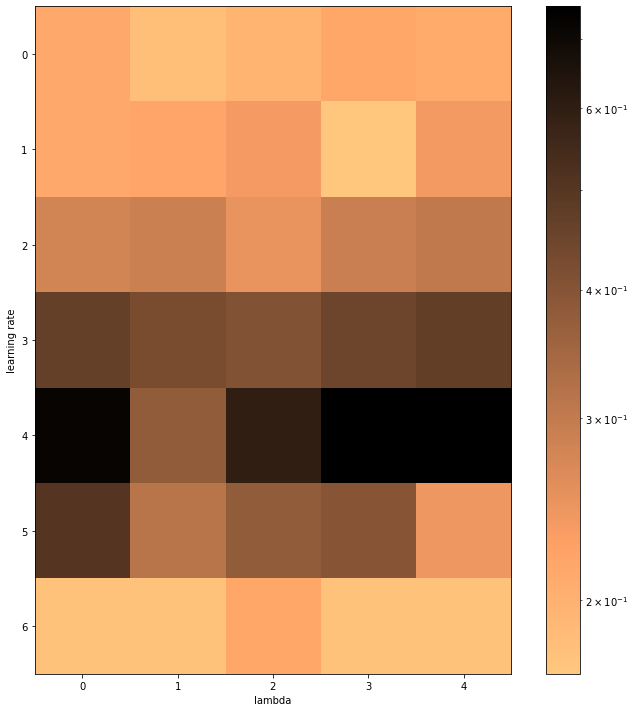

In [91]:
from matplotlib import colors as cl
to_plot = []
for lr in range(7):
  row = []
  for lamda in range(5):
    row.append(results_dcasgd[lr][lamda][-1])
  to_plot.append(row)
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
data2D = results
im = plt.imshow(to_plot, cmap="copper_r", norm=cl.LogNorm())
plt.xlabel('lambda')
plt.ylabel('learning rate')
plt.colorbar(im)
plt.show()

we can keep lr = 0.05 and lamda 0.1

# SGD

In [81]:
epochs=8
results = []
for i, lr in enumerate(np.logspace(-4,0,7)) :
  print(i) 
  model = TextClassifier()
  model.initialize()
  loss_func = loss.SoftmaxCrossEntropyLoss()
  dcasgd_optimizer = optimizer.SGD(learning_rate=lr, momentum = 0)

  trainer = gluon.Trainer(model.collect_params(), dcasgd_optimizer)

  accuracies = TrainModelInBatches(trainer, train_loader, test_loader, epochs)
  results.append(accuracies)

0


100%|██████████| 22/22 [00:04<00:00,  5.14it/s]


Train CrossEntropyLoss : 1.630
Valid CrossEntropyLoss : 1.628
Valid Accuracy : 0.210


100%|██████████| 22/22 [00:03<00:00,  6.22it/s]


Train CrossEntropyLoss : 1.629
Valid CrossEntropyLoss : 1.627
Valid Accuracy : 0.209


100%|██████████| 22/22 [00:03<00:00,  6.31it/s]


Train CrossEntropyLoss : 1.628
Valid CrossEntropyLoss : 1.626
Valid Accuracy : 0.208


100%|██████████| 22/22 [00:03<00:00,  6.22it/s]


Train CrossEntropyLoss : 1.627
Valid CrossEntropyLoss : 1.626
Valid Accuracy : 0.205


100%|██████████| 22/22 [00:03<00:00,  6.24it/s]


Train CrossEntropyLoss : 1.626
Valid CrossEntropyLoss : 1.625
Valid Accuracy : 0.206


100%|██████████| 22/22 [00:03<00:00,  6.23it/s]


Train CrossEntropyLoss : 1.626
Valid CrossEntropyLoss : 1.625
Valid Accuracy : 0.207


100%|██████████| 22/22 [00:03<00:00,  6.24it/s]


Train CrossEntropyLoss : 1.625
Valid CrossEntropyLoss : 1.624
Valid Accuracy : 0.207


100%|██████████| 22/22 [00:03<00:00,  6.25it/s]


Train CrossEntropyLoss : 1.624
Valid CrossEntropyLoss : 1.623
Valid Accuracy : 0.208
1


100%|██████████| 22/22 [00:03<00:00,  5.91it/s]


Train CrossEntropyLoss : 1.625
Valid CrossEntropyLoss : 1.620
Valid Accuracy : 0.199


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train CrossEntropyLoss : 1.622
Valid CrossEntropyLoss : 1.618
Valid Accuracy : 0.200


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train CrossEntropyLoss : 1.619
Valid CrossEntropyLoss : 1.617
Valid Accuracy : 0.205


100%|██████████| 22/22 [00:03<00:00,  6.23it/s]


Train CrossEntropyLoss : 1.617
Valid CrossEntropyLoss : 1.615
Valid Accuracy : 0.209


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train CrossEntropyLoss : 1.615
Valid CrossEntropyLoss : 1.614
Valid Accuracy : 0.214


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train CrossEntropyLoss : 1.613
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:03<00:00,  6.23it/s]


Train CrossEntropyLoss : 1.611
Valid CrossEntropyLoss : 1.612
Valid Accuracy : 0.223


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train CrossEntropyLoss : 1.610
Valid CrossEntropyLoss : 1.611
Valid Accuracy : 0.227
2


100%|██████████| 22/22 [00:03<00:00,  6.04it/s]


Train CrossEntropyLoss : 1.623
Valid CrossEntropyLoss : 1.612
Valid Accuracy : 0.214


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train CrossEntropyLoss : 1.611
Valid CrossEntropyLoss : 1.605
Valid Accuracy : 0.223


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train CrossEntropyLoss : 1.604
Valid CrossEntropyLoss : 1.601
Valid Accuracy : 0.231


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train CrossEntropyLoss : 1.599
Valid CrossEntropyLoss : 1.597
Valid Accuracy : 0.237


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train CrossEntropyLoss : 1.595
Valid CrossEntropyLoss : 1.594
Valid Accuracy : 0.250


100%|██████████| 22/22 [00:03<00:00,  6.22it/s]


Train CrossEntropyLoss : 1.592
Valid CrossEntropyLoss : 1.592
Valid Accuracy : 0.263


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train CrossEntropyLoss : 1.588
Valid CrossEntropyLoss : 1.589
Valid Accuracy : 0.268


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train CrossEntropyLoss : 1.585
Valid CrossEntropyLoss : 1.587
Valid Accuracy : 0.277
3


100%|██████████| 22/22 [00:03<00:00,  6.01it/s]


Train CrossEntropyLoss : 1.616
Valid CrossEntropyLoss : 1.601
Valid Accuracy : 0.237


100%|██████████| 22/22 [00:03<00:00,  6.24it/s]


Train CrossEntropyLoss : 1.593
Valid CrossEntropyLoss : 1.590
Valid Accuracy : 0.274


100%|██████████| 22/22 [00:03<00:00,  6.25it/s]


Train CrossEntropyLoss : 1.581
Valid CrossEntropyLoss : 1.579
Valid Accuracy : 0.302


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 1.568
Valid CrossEntropyLoss : 1.568
Valid Accuracy : 0.339


100%|██████████| 22/22 [00:03<00:00,  6.25it/s]


Train CrossEntropyLoss : 1.556
Valid CrossEntropyLoss : 1.556
Valid Accuracy : 0.369


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train CrossEntropyLoss : 1.543
Valid CrossEntropyLoss : 1.544
Valid Accuracy : 0.394


100%|██████████| 22/22 [00:03<00:00,  6.25it/s]


Train CrossEntropyLoss : 1.529
Valid CrossEntropyLoss : 1.530
Valid Accuracy : 0.429


100%|██████████| 22/22 [00:03<00:00,  6.25it/s]


Train CrossEntropyLoss : 1.513
Valid CrossEntropyLoss : 1.516
Valid Accuracy : 0.453
4


100%|██████████| 22/22 [00:03<00:00,  6.02it/s]


Train CrossEntropyLoss : 1.584
Valid CrossEntropyLoss : 1.569
Valid Accuracy : 0.304


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train CrossEntropyLoss : 1.525
Valid CrossEntropyLoss : 1.517
Valid Accuracy : 0.365


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train CrossEntropyLoss : 1.446
Valid CrossEntropyLoss : 1.445
Valid Accuracy : 0.437


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train CrossEntropyLoss : 1.316
Valid CrossEntropyLoss : 1.394
Valid Accuracy : 0.437


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train CrossEntropyLoss : 1.174
Valid CrossEntropyLoss : 1.170
Valid Accuracy : 0.615


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train CrossEntropyLoss : 1.074
Valid CrossEntropyLoss : 1.120
Valid Accuracy : 0.620


100%|██████████| 22/22 [00:03<00:00,  6.22it/s]


Train CrossEntropyLoss : 0.988
Valid CrossEntropyLoss : 0.916
Valid Accuracy : 0.729


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train CrossEntropyLoss : 0.690
Valid CrossEntropyLoss : 0.818
Valid Accuracy : 0.742
5


100%|██████████| 22/22 [00:03<00:00,  6.07it/s]


Train CrossEntropyLoss : 1.617
Valid CrossEntropyLoss : 1.574
Valid Accuracy : 0.301


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train CrossEntropyLoss : 1.572
Valid CrossEntropyLoss : 1.497
Valid Accuracy : 0.362


100%|██████████| 22/22 [00:03<00:00,  6.24it/s]


Train CrossEntropyLoss : 1.557
Valid CrossEntropyLoss : 1.498
Valid Accuracy : 0.440


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train CrossEntropyLoss : 1.436
Valid CrossEntropyLoss : 1.606
Valid Accuracy : 0.306


100%|██████████| 22/22 [00:03<00:00,  6.31it/s]


Train CrossEntropyLoss : 1.373
Valid CrossEntropyLoss : 1.262
Valid Accuracy : 0.440


100%|██████████| 22/22 [00:03<00:00,  6.24it/s]


Train CrossEntropyLoss : 1.221
Valid CrossEntropyLoss : 1.207
Valid Accuracy : 0.524


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train CrossEntropyLoss : 1.200
Valid CrossEntropyLoss : 1.263
Valid Accuracy : 0.512


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train CrossEntropyLoss : 1.144
Valid CrossEntropyLoss : 3.051
Valid Accuracy : 0.377
6


100%|██████████| 22/22 [00:03<00:00,  6.03it/s]


Train CrossEntropyLoss : 1.889
Valid CrossEntropyLoss : 1.741
Valid Accuracy : 0.218


100%|██████████| 22/22 [00:03<00:00,  6.23it/s]


Train CrossEntropyLoss : 1.715
Valid CrossEntropyLoss : 1.595
Valid Accuracy : 0.232


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train CrossEntropyLoss : 1.644
Valid CrossEntropyLoss : 2.771
Valid Accuracy : 0.224


100%|██████████| 22/22 [00:03<00:00,  6.24it/s]


Train CrossEntropyLoss : 2.231
Valid CrossEntropyLoss : 1.600
Valid Accuracy : 0.221


100%|██████████| 22/22 [00:03<00:00,  6.25it/s]


Train CrossEntropyLoss : 1.619
Valid CrossEntropyLoss : 1.552
Valid Accuracy : 0.252


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train CrossEntropyLoss : 1.665
Valid CrossEntropyLoss : 1.585
Valid Accuracy : 0.234


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train CrossEntropyLoss : 1.605
Valid CrossEntropyLoss : 1.578
Valid Accuracy : 0.234


100%|██████████| 22/22 [00:03<00:00,  6.24it/s]


Train CrossEntropyLoss : 1.659
Valid CrossEntropyLoss : 1.597
Valid Accuracy : 0.241


In [82]:
results = np.array(results)

Text(0, 0.5, 'accuracy')

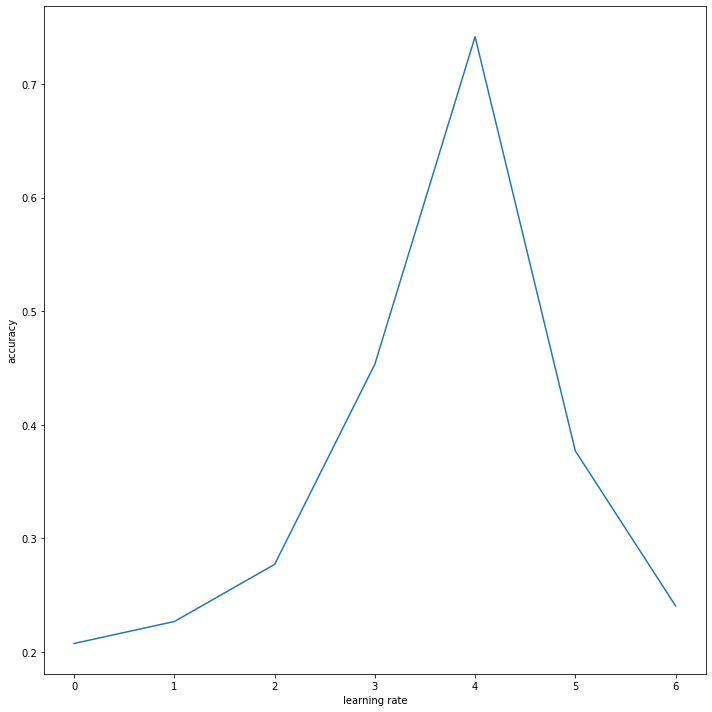

In [83]:
plt.plot(results[:,-1])
plt.xlabel('learning rate')
plt.ylabel('accuracy')

select learning rate 0.05

# Compare the two algorithms

# SGD

In [105]:
lr = 0.05 
lamda = 0.2
epochs = 30

In [100]:
!pip install pytictoc
from pytictoc import TicToc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
model = TextClassifier()
model.initialize()
loss_func = loss.SoftmaxCrossEntropyLoss()
dcasgd_optimizer = optimizer.SGD(learning_rate=lr, momentum = 0)

trainer = gluon.Trainer(model.collect_params(), dcasgd_optimizer)

t = TicToc() #create instance of class
t.tic() #Start timer
accuracies = TrainModelInBatches(trainer, train_loader, test_loader, epochs)
t.toc() #Time elapsed since t.tic()

100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train CrossEntropyLoss : 1.590
Valid CrossEntropyLoss : 1.572
Valid Accuracy : 0.290


100%|██████████| 22/22 [00:03<00:00,  6.42it/s]


Train CrossEntropyLoss : 1.532
Valid CrossEntropyLoss : 1.521
Valid Accuracy : 0.346


100%|██████████| 22/22 [00:03<00:00,  6.40it/s]


Train CrossEntropyLoss : 1.456
Valid CrossEntropyLoss : 1.449
Valid Accuracy : 0.424


100%|██████████| 22/22 [00:03<00:00,  6.38it/s]


Train CrossEntropyLoss : 1.335
Valid CrossEntropyLoss : 1.376
Valid Accuracy : 0.477


100%|██████████| 22/22 [00:03<00:00,  6.39it/s]


Train CrossEntropyLoss : 1.224
Valid CrossEntropyLoss : 1.256
Valid Accuracy : 0.583


100%|██████████| 22/22 [00:03<00:00,  6.41it/s]


Train CrossEntropyLoss : 1.294
Valid CrossEntropyLoss : 1.168
Valid Accuracy : 0.694


100%|██████████| 22/22 [00:03<00:00,  6.35it/s]


Train CrossEntropyLoss : 0.931
Valid CrossEntropyLoss : 0.962
Valid Accuracy : 0.723


100%|██████████| 22/22 [00:03<00:00,  6.42it/s]


Train CrossEntropyLoss : 0.801
Valid CrossEntropyLoss : 0.844
Valid Accuracy : 0.760


100%|██████████| 22/22 [00:03<00:00,  6.38it/s]


Train CrossEntropyLoss : 0.625
Valid CrossEntropyLoss : 0.843
Valid Accuracy : 0.739


100%|██████████| 22/22 [00:03<00:00,  6.37it/s]


Train CrossEntropyLoss : 0.491
Valid CrossEntropyLoss : 0.696
Valid Accuracy : 0.785


100%|██████████| 22/22 [00:03<00:00,  6.37it/s]


Train CrossEntropyLoss : 0.996
Valid CrossEntropyLoss : 0.729
Valid Accuracy : 0.772


100%|██████████| 22/22 [00:03<00:00,  6.39it/s]


Train CrossEntropyLoss : 0.699
Valid CrossEntropyLoss : 0.797
Valid Accuracy : 0.769


100%|██████████| 22/22 [00:03<00:00,  6.48it/s]


Train CrossEntropyLoss : 0.365
Valid CrossEntropyLoss : 0.541
Valid Accuracy : 0.837


100%|██████████| 22/22 [00:03<00:00,  6.42it/s]


Train CrossEntropyLoss : 0.259
Valid CrossEntropyLoss : 0.498
Valid Accuracy : 0.847


100%|██████████| 22/22 [00:03<00:00,  6.42it/s]


Train CrossEntropyLoss : 0.209
Valid CrossEntropyLoss : 0.464
Valid Accuracy : 0.856


100%|██████████| 22/22 [00:03<00:00,  6.39it/s]


Train CrossEntropyLoss : 0.175
Valid CrossEntropyLoss : 0.438
Valid Accuracy : 0.866


100%|██████████| 22/22 [00:03<00:00,  6.43it/s]


Train CrossEntropyLoss : 0.149
Valid CrossEntropyLoss : 0.418
Valid Accuracy : 0.875


100%|██████████| 22/22 [00:03<00:00,  6.38it/s]


Train CrossEntropyLoss : 0.127
Valid CrossEntropyLoss : 0.403
Valid Accuracy : 0.880


100%|██████████| 22/22 [00:03<00:00,  6.45it/s]


Train CrossEntropyLoss : 0.109
Valid CrossEntropyLoss : 0.393
Valid Accuracy : 0.883


100%|██████████| 22/22 [00:03<00:00,  6.31it/s]


Train CrossEntropyLoss : 0.095
Valid CrossEntropyLoss : 0.385
Valid Accuracy : 0.886


100%|██████████| 22/22 [00:03<00:00,  6.39it/s]


Train CrossEntropyLoss : 0.083
Valid CrossEntropyLoss : 0.379
Valid Accuracy : 0.891


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train CrossEntropyLoss : 0.074
Valid CrossEntropyLoss : 0.375
Valid Accuracy : 0.892


100%|██████████| 22/22 [00:03<00:00,  6.41it/s]


Train CrossEntropyLoss : 0.066
Valid CrossEntropyLoss : 0.372
Valid Accuracy : 0.896


100%|██████████| 22/22 [00:03<00:00,  6.42it/s]


Train CrossEntropyLoss : 0.059
Valid CrossEntropyLoss : 0.369
Valid Accuracy : 0.898


100%|██████████| 22/22 [00:03<00:00,  6.37it/s]


Train CrossEntropyLoss : 0.053
Valid CrossEntropyLoss : 0.367
Valid Accuracy : 0.899


100%|██████████| 22/22 [00:03<00:00,  6.40it/s]


Train CrossEntropyLoss : 0.048
Valid CrossEntropyLoss : 0.366
Valid Accuracy : 0.900


100%|██████████| 22/22 [00:03<00:00,  6.37it/s]


Train CrossEntropyLoss : 0.044
Valid CrossEntropyLoss : 0.365
Valid Accuracy : 0.902


100%|██████████| 22/22 [00:03<00:00,  6.37it/s]


Train CrossEntropyLoss : 0.040
Valid CrossEntropyLoss : 0.364
Valid Accuracy : 0.902


100%|██████████| 22/22 [00:03<00:00,  6.34it/s]


Train CrossEntropyLoss : 0.037
Valid CrossEntropyLoss : 0.364
Valid Accuracy : 0.901


100%|██████████| 22/22 [00:03<00:00,  6.35it/s]


Train CrossEntropyLoss : 0.034
Valid CrossEntropyLoss : 0.364
Valid Accuracy : 0.902
Elapsed time is 170.587249 seconds.


# DC ASGD

In [106]:
model = TextClassifier()
model.initialize()
loss_func = loss.SoftmaxCrossEntropyLoss()
dcasgd_optimizer = optimizer.DCASGD(learning_rate=lr, lamda = lamda)

trainer = gluon.Trainer(model.collect_params(), dcasgd_optimizer)

t = TicToc() #create instance of class
t.tic() #Start timer
accuracies = TrainModelInBatches(trainer, train_loader, test_loader, epochs)
t.toc() #Time elapsed since t.tic()

100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


Train CrossEntropyLoss : 1.588
Valid CrossEntropyLoss : 1.569
Valid Accuracy : 0.300


100%|██████████| 22/22 [00:03<00:00,  5.62it/s]


Train CrossEntropyLoss : 1.521
Valid CrossEntropyLoss : 1.522
Valid Accuracy : 0.364


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.427
Valid CrossEntropyLoss : 1.448
Valid Accuracy : 0.426


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 1.277
Valid CrossEntropyLoss : 1.438
Valid Accuracy : 0.459


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 1.406
Valid CrossEntropyLoss : 1.613
Valid Accuracy : 0.365


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 1.203
Valid CrossEntropyLoss : 1.047
Valid Accuracy : 0.694


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 0.854
Valid CrossEntropyLoss : 0.892
Valid Accuracy : 0.738


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 0.911
Valid CrossEntropyLoss : 0.794
Valid Accuracy : 0.759


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 0.601
Valid CrossEntropyLoss : 0.725
Valid Accuracy : 0.771


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train CrossEntropyLoss : 0.479
Valid CrossEntropyLoss : 0.676
Valid Accuracy : 0.786


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 0.828
Valid CrossEntropyLoss : 0.636
Valid Accuracy : 0.803


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 0.360
Valid CrossEntropyLoss : 0.572
Valid Accuracy : 0.819


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 0.284
Valid CrossEntropyLoss : 0.527
Valid Accuracy : 0.844


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 0.231
Valid CrossEntropyLoss : 0.492
Valid Accuracy : 0.851


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train CrossEntropyLoss : 0.192
Valid CrossEntropyLoss : 0.469
Valid Accuracy : 0.861


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 0.162
Valid CrossEntropyLoss : 0.449
Valid Accuracy : 0.866


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 0.137
Valid CrossEntropyLoss : 0.441
Valid Accuracy : 0.871


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 0.117
Valid CrossEntropyLoss : 0.429
Valid Accuracy : 0.875


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train CrossEntropyLoss : 0.101
Valid CrossEntropyLoss : 0.419
Valid Accuracy : 0.876


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 0.089
Valid CrossEntropyLoss : 0.410
Valid Accuracy : 0.879


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train CrossEntropyLoss : 0.078
Valid CrossEntropyLoss : 0.403
Valid Accuracy : 0.883


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 0.069
Valid CrossEntropyLoss : 0.396
Valid Accuracy : 0.886


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train CrossEntropyLoss : 0.061
Valid CrossEntropyLoss : 0.392
Valid Accuracy : 0.888


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train CrossEntropyLoss : 0.055
Valid CrossEntropyLoss : 0.388
Valid Accuracy : 0.891


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 0.050
Valid CrossEntropyLoss : 0.386
Valid Accuracy : 0.891


100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


Train CrossEntropyLoss : 0.045
Valid CrossEntropyLoss : 0.385
Valid Accuracy : 0.893


100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


Train CrossEntropyLoss : 0.041
Valid CrossEntropyLoss : 0.384
Valid Accuracy : 0.896


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train CrossEntropyLoss : 0.037
Valid CrossEntropyLoss : 0.383
Valid Accuracy : 0.895


100%|██████████| 22/22 [00:03<00:00,  5.70it/s]


Train CrossEntropyLoss : 0.034
Valid CrossEntropyLoss : 0.383
Valid Accuracy : 0.898


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train CrossEntropyLoss : 0.031
Valid CrossEntropyLoss : 0.383
Valid Accuracy : 0.899
Elapsed time is 184.710651 seconds.


Here, the additionnal term of the hessian doesn't lead to better performance, but doesn't decrease accuracy either. The time of operation between the two algorithm is less that 10% of SGD's runtime, which leads us to think that the DCASGD would be ideal for nlp with a cluster of GPUs.